In [0]:
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
test_labels = y_test.T[0]
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
def normalization(images):
    images = images.reshape(-1, 3072)
    each_pixel_mean = images.mean(axis=0)
    each_pixel_std = np.std(images, axis=0)
    images = np.divide(np.subtract(images, each_pixel_mean), each_pixel_std)
    return images.reshape(-1, 32, 32, 3)

In [0]:
train_pixels, one_hot_train_labels = normalization(x_train), y_train
test_pixels, one_hot_test_labels = normalization(x_test), y_test

In [0]:
def new_batch():
    train_index = 0
    def get_batch(total_x, total_y, batch_size):
        nonlocal train_index
        num = total_x.shape[0]
        start = train_index
        train_index += batch_size
        # shuffle training data when all data has been used
        if train_index > num:
            start = 0
            train_index = batch_size
            re_order = np.random.shuffle(np.arange(num))
            total_x = total_x[re_order][0]
            total_y = total_y[re_order][0]
        end = train_index
        return total_x[start:end], total_y[start:end]
    return get_batch

In [0]:
def conv2d_maxpool(x_tensor, conv_output_num):
    W_shape = [3, 3] + [int(x_tensor.shape[3]), conv_output_num]
    W = tf.Variable(tf.truncated_normal(W_shape, stddev=.05))
    x = tf.nn.conv2d(x_tensor, W, strides=[1, 1, 1, 1], padding='SAME')
    b = tf.Variable(tf.zeros([conv_output_num]))
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def dense(x_tensor, output_num):
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), output_num], stddev=.05))
    b = tf.Variable(tf.zeros([output_num]))
    return tf.add(tf.matmul(x_tensor, W), b)

def CNN(x_tensor, keep_prob):
    x = conv2d_maxpool(x_tensor, 64)
    x = conv2d_maxpool(x, 128)
    x = conv2d_maxpool(x, 256)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.reshape(x, [-1, np.prod(x.shape.as_list()[1:])])
    x = dense(x, 1024)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, keep_prob)
    x = dense(x, 512)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, keep_prob)
    return dense(x, 10)

In [13]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 32, 32, 3], name="x")
y = tf.placeholder(tf.float32, [None, 10], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
cifar10 = CNN(x, keep_prob)
cifar10 = tf.identity(cifar10, name='cifar10')
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=cifar10, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
prediction = tf.argmax(cifar10, 1)
correct_pred = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [0]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
epochs = 2900
batch_size = 1024
keepProb = 0.5
iter_display = 1
get_new_batch = new_batch()

In [15]:
for i in range(epochs):
    batch_x, batch_y = get_new_batch(train_pixels, one_hot_train_labels, batch_size)
    if (i % iter_display) == 0 or i == (epochs-1):
        if (i == 10 or i == 100) and iter_display < 100:
            iter_display *= 10
        train_accuracy = accuracy.eval(feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        test_accuracy = accuracy.eval(feed_dict={x: test_pixels, y: one_hot_test_labels, keep_prob: 1.0})
        print('Epoch %d: training accuracy=%.2f, test_accuracy=%.2f' % (i, train_accuracy, test_accuracy))
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: keepProb})

Epoch 0: training accuracy=0.10, test_accuracy=0.10
Epoch 1: training accuracy=0.14, test_accuracy=0.16
Epoch 2: training accuracy=0.17, test_accuracy=0.16
Epoch 3: training accuracy=0.18, test_accuracy=0.17
Epoch 4: training accuracy=0.21, test_accuracy=0.19
Epoch 5: training accuracy=0.21, test_accuracy=0.23
Epoch 6: training accuracy=0.21, test_accuracy=0.23
Epoch 7: training accuracy=0.22, test_accuracy=0.23
Epoch 8: training accuracy=0.21, test_accuracy=0.22
Epoch 9: training accuracy=0.22, test_accuracy=0.23
Epoch 10: training accuracy=0.24, test_accuracy=0.23
Epoch 20: training accuracy=0.30, test_accuracy=0.29
Epoch 30: training accuracy=0.35, test_accuracy=0.35
Epoch 40: training accuracy=0.39, test_accuracy=0.40
Epoch 50: training accuracy=0.44, test_accuracy=0.44
Epoch 60: training accuracy=0.45, test_accuracy=0.46
Epoch 70: training accuracy=0.50, test_accuracy=0.49
Epoch 80: training accuracy=0.45, test_accuracy=0.50
Epoch 90: training accuracy=0.52, test_accuracy=0.53
Epo

In [16]:
predict_labels = prediction.eval(feed_dict={x: test_pixels, y: one_hot_test_labels, keep_prob: 1.0})

def confusion_matrix(actual, predict):
    cmatrix = np.zeros((10, 10)).astype(int)
    for i in range(10000):
        if actual[i] == predict[i]:
            cmatrix[actual[i]][actual[i]] += 1
        else:
            cmatrix[actual[i]][predict[i]] += 1
    return cmatrix

cm = confusion_matrix(test_labels, predict_labels)
print(cm)

[[833  11  19  14  25   4   4  15  54  21]
 [  8 921   0   6   3   1   6   1  12  42]
 [ 44   2 704  44  97  32  43  21  11   2]
 [ 10   7  32 680  73 106  45  33   5   9]
 [  5   2  31  25 869  11  19  36   1   1]
 [  9   3  29 148  61 690  19  35   2   4]
 [  3   3  34  47  43  10 851   4   3   2]
 [  8   1  15  25  41  26   0 879   1   4]
 [ 32  15   4  11   9   3   2   4 905  15]
 [ 24  56   6   8   2   2   5  10  11 876]]


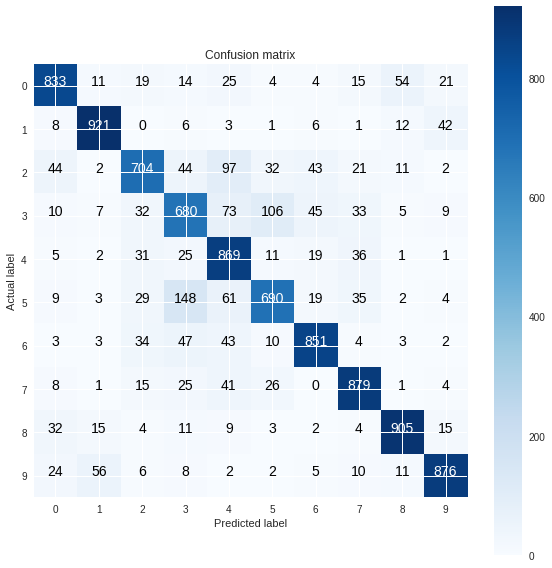

In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, label_num):
    labels = range(label_num)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    marks = np.arange(len(labels))
    plt.xticks(marks, labels)
    plt.yticks(marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]), fontsize=14,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, 10)

In [0]:
sess.close()